In [863]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from pathlib import Path

### Merging evaluation systems results

In [864]:
statistics_path = os.path.join(os.sep, "home", "data")

query_statistics_output_file  = os.path.join(statistics_path, "query_statistics.csv")
ingestion_statistics_output_file = os.path.join(statistics_path, "ingestion_statistics.csv")

figures_path = os.path.join(os.sep, "home", "figures")

In [865]:
for path in (query_statistics_output_file, ingestion_statistics_output_file):
    Path(path).unlink(missing_ok=True)

ingestion_statistics = pd.DataFrame()
query_statistics = pd.DataFrame()

# Aggregate different systems results

for evaluated_system in os.listdir(statistics_path):
    if os.path.isdir(os.path.join(statistics_path, evaluated_system)):
        ingestion_file = os.path.join(statistics_path, evaluated_system, "ingestion_time","ingestion_statistics.csv")
        query_file = os.path.join(statistics_path, evaluated_system, "query_evaluation","statistics.csv")
        if os.path.exists(ingestion_file):
            ingestion_statistics = pd.concat([ingestion_statistics, pd.read_csv(ingestion_file)], ignore_index=True)
        query_statistics = pd.concat([query_statistics, pd.read_csv(query_file)], ignore_index=True)

ingestion_statistics["datasetSize"] = ingestion_statistics["datasetSize"].apply(lambda x: str.capitalize(x))
query_statistics["datasetSize"] = query_statistics["datasetSize"].apply(lambda x: str.capitalize(x))

ingestion_statistics.to_csv(ingestion_statistics_output_file, index=False )
query_statistics.to_csv(query_statistics_output_file, index=False )

In [866]:
# Delete old statistics
for path in (query_statistics_output_file, ingestion_statistics_output_file):
    Path(path).unlink(missing_ok=True)

ingestion_statistics = pd.DataFrame()
query_statistics = pd.DataFrame()

# Aggregate different systems results

for evaluated_system in os.listdir(statistics_path):
    if os.path.isdir(os.path.join(statistics_path, evaluated_system)):
        ingestion_file = os.path.join(statistics_path, evaluated_system, "ingestion_time","ingestion_statistics.csv")
        query_file = os.path.join(statistics_path, evaluated_system, "query_evaluation","statistics.csv")
        if evaluated_system == "pgage":
            pgage = pd.read_csv(ingestion_file)
            # pgage['iteration'] = range(1, len(pgage) + 1)
            # pgage["startTimestamp"] = round(pgage["startTimestamp"]/10,0)
            # pgage["endTimestamp"] = round(pgage["endTimestamp"]/10,0)
            # pgage["graphElapsedTime"] = round(pgage["graphElapsedTime"] * 1000,0)
            # pgage["tsElapsedTime"] = round(pgage["tsElapsedTime"] * 1000,0)
            # pgage["elapsedTime"] = round(pgage["elapsedTime"] * 1000,0)
            # pgage.to_csv(ingestion_file, index=False)
        # query = pd.read_csv(query_file)
        # query.drop(columns=["iteration"], inplace=True)
        # query["temporalRangeIndex"] = 0
        # if (query["model"] == "STGraph").all():
        #     query = add_iteration_column(query, ["model","dataset","datasetSize","queryName","threads","queryType","querySelectivity","numMachines"])
        # else:
        #     query = add_iteration_column(query, ["test_id","model","dataset","datasetSize","threads","queryName","queryType","querySelectivity","numMachines"])
        # query.to_csv(query_file, index=False)
        if os.path.exists(ingestion_file):
            ingestion_statistics = pd.concat([ingestion_statistics, pd.read_csv(ingestion_file)], ignore_index=True)
        query_statistics = pd.concat([query_statistics, pd.read_csv(query_file)], ignore_index=True)

ingestion_statistics["datasetSize"] = ingestion_statistics["datasetSize"].apply(lambda x: str.capitalize(x))
query_statistics["datasetSize"] = query_statistics["datasetSize"].apply(lambda x: str.capitalize(x))

ingestion_statistics.to_csv(ingestion_statistics_output_file, index=False )
query_statistics.to_csv(query_statistics_output_file, index=False )

Utils

In [867]:
query_names = {
    "EnvironmentCoverage": "Q1",
    "EnvironmentAggregate": "Q2",
    "MaintenanceOwners": "Q3",
    "EnvironmentAlert": "Q4",
    "EnvironmentOutlier": "Q4",
    "AgentOutlier": "Q5",
    "AgentHistory": "Q6"
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
patterns = ['solid', '...', '///', '/', '|', '-', '+', 'x', 'o', 'O', '.', '*']              # hatch patterns for consistency

## Generating figures

Utility functions

In [ ]:
def print_ingestion_statistics(ingestion_statistics: pd.DataFrame):
    """
    Print ingestion statistics bar plot (log scale, clipped values, scalable patterns),
    con padding minimo sopra il limite di clipping.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import os

    df = ingestion_statistics.copy(deep=True)
    df = df[df["threads"] == 1]

    grouped = df.groupby(["datasetSize", "model"])["elapsedTime"].mean().reset_index()

    dataset_order = ["Small", "Large", "Big"]
    grouped["datasetSize"] = pd.Categorical(grouped["datasetSize"], categories=dataset_order, ordered=True)

    all_models = sorted(grouped["model"].unique())
    num_models = len(all_models)

    # Palette colori e pattern coerenti
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'violet']
    patterns = ['/', '\\', 'x', 'o', '.']

    bar_width = min(0.8 / num_models, 0.18)
    x = np.arange(len(dataset_order))

    fig, ax = plt.subplots(figsize=(6 * len(dataset_order), 4))

    # Valore di clipping per gestire i fuori scala (es. AeonG)
    CLIP_VALUE = 1e8

    for i, model in enumerate(all_models):
        offset = (i - (num_models - 1) / 2) * bar_width
        for j, ds in enumerate(dataset_order):
            subset = grouped[(grouped["datasetSize"] == ds) & (grouped["model"] == model)]
            if subset.empty:
                continue
                
            value = subset["elapsedTime"].values[0]
            display_value = min(value, CLIP_VALUE)

            ax.bar(
                x[j] + offset,
                display_value,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor='black',
                hatch=patterns[i % len(patterns)],
                label=model if j == 0 else None
            )

            # Etichetta per valori troncati
            if value > CLIP_VALUE:
                ax.text(
                    x[j] + offset, 
                    CLIP_VALUE * 1.1, # Posizionato appena sopra il limite di clipping
                    f"{value:.2e}",
                    va='bottom',
                    ha='center', # Centrato sulla barra per pulizia estetica
                    fontsize=14,
                    rotation=0,
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.9, pad=1.5)
                )

    ax.set_xticks(x)
    ax.set_xticklabels(dataset_order, fontsize=16)
    ax.set_xlabel("Dataset Size", fontsize=16)

    ax.set_yscale("log")
    
    # --- OTTIMIZZAZIONE PADDING ---
    # Impostiamo il limite Y basandoci sul CLIP_VALUE invece che sul valore massimo reale.
    # Un moltiplicatore di 3.0 in scala logaritmica lascia uno spazio minimo e pulito.
    ax.set_ylim(1, CLIP_VALUE * 3.5) 
    
    ax.tick_params(axis='y', which='both', length=6, labelsize=16)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, which='major')
    ax.set_ylabel("Avg. Elapsed Time (ms)", fontsize=16)

    # Legenda personalizzata
    handles = [
        mpatches.Patch(facecolor=colors[i % len(colors)],
                       hatch=patterns[i % len(patterns)],
                       edgecolor='black',
                       label=model)
        for i, model in enumerate(all_models)
    ]

    fig.legend(
        handles=handles,
        loc='upper center',
        ncol=len(all_models),
        frameon=False,
        bbox_to_anchor=(0.5, 1.1), # Spostata leggermente più su per non sovrapporsi alle barre
        fontsize=18
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Salvataggio e visualizzazione
    plt.savefig(os.path.join(figures_path, "ingestion_statistics.svg"), format='svg', bbox_inches='tight')
    plt.show()

def print_query_statistics(query_statistics: pd.DataFrame, name="query_statistics"):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter

    # --- Formatter per asse Y log in notazione 10^X ---
    def scientific_y(x, pos):
        if x <= 0:
            return "0"
        exponent = int(np.log10(x))
        return f"$10^{exponent}$"

    query_df = query_statistics.copy(deep=True)
    query_df = query_df[query_df["datasetSize"] != "big_long"]

    query_names = {
        "EnvironmentCoverage": "Q1",
        "EnvironmentAggregate": "Q2",
        "MaintenanceOwners": "Q3",
        "EnvironmentAlert": "Q4",
        "EnvironmentOutlier": "Q4",
        "AgentOutlier": "Q5",
        "AgentHistory": "Q6",
    }
    query_df["queryID"] = query_df["queryName"].map(query_names)
    query_df = query_df.dropna(subset=["queryID"])

    dataset_sizes = ["Small", "Large", "Big"]

    fig, axes = plt.subplots(
        1,
        len(dataset_sizes),
        figsize=(6 * len(dataset_sizes), 4),
        sharey=True
    )
    if len(dataset_sizes) == 1:
        axes = [axes]

    all_models = sorted(query_df["model"].unique())
    num_models = len(all_models)
    bar_width = min(0.8 / num_models, 0.18)

    # --- Colori e pattern ---
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'violet']
    patterns = ['/', '\\', 'x', 'o', '.']

    for ax, ds in zip(axes, dataset_sizes):
        df_filtered = query_df[
            (query_df["threads"] == 1) &
            (query_df["datasetSize"] == ds)
        ]

        grouped = (
            df_filtered
            .groupby(["queryID", "model"])["elapsedTime"]
            .mean()
            .reset_index()
        )

        query_ids = sorted(grouped["queryID"].unique())
        x = np.arange(len(query_ids))

        for i, model in enumerate(all_models):
            values = [
                grouped[
                    (grouped["queryID"] == q) &
                    (grouped["model"] == model)
                ]["elapsedTime"].values[0]
                if not grouped[
                    (grouped["queryID"] == q) &
                    (grouped["model"] == model)
                ].empty
                else np.nan
                for q in query_ids
            ]

            offset = (i - (num_models - 1) / 2) * bar_width

            ax.bar(
                x + offset,
                values,
                width=bar_width,
                color=colors[i % len(colors)],
                edgecolor="black",
                hatch=patterns[i % len(patterns)],
                label=model if ds == dataset_sizes[0] else None
            )

        # --- X axis ---
        ax.set_xticks(x)
        ax.set_xticklabels(query_ids, fontsize=16)  # tick X più grandi

        # --- Y axis ---
        ax.set_yscale("log")
        ax.set_ylim(1, 1e8)
        ax.yaxis.set_major_formatter(FuncFormatter(scientific_y))
        ax.tick_params(axis="y", which="major", labelsize=16)
        ax.tick_params(axis="y", which="both", length=0)
        ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5)

        ax.set_title(ds, fontsize=18)
        ax.margins(x=0.05)

    # --- Label globali ---
    fig.supxlabel("Query ID", fontsize=18)
    #fig.supylabel("Latency (ms)", fontsize=16)
    ylabel = fig.supylabel("Latency (ms)", fontsize=18)
    ylabel.set_position((-0.00005, 0.5))  # sposta più vicino ai tick senza sovrapporsi

    # --- Legenda sopra i grafici ---
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=len(all_models),
        frameon=False,
        fontsize=18
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # margini ottimizzati
    plt.savefig(os.path.join(figures_path, "query_statistics.svg"), format='svg', bbox_inches='tight')
    plt.show()


In [ ]:
def plot_execution_times_selectivity(df, dataset_size, threads):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import numpy as np
    import os

    model_mapping = {
        "AeonG":    {"color": "skyblue",    "marker": "o"},
        "HyGraph":  {"color": "salmon",     "marker": "s"},
        "Neo4J":    {"color": "lightgreen", "marker": "^"},
        "PGAge":    {"color": "orange",     "marker": "D"},
        "STGraph":  {"color": "violet",     "marker": "v"}
    }

    coverage_map = {i: round((i + 1) * 10, 1) for i in range(10)}
    query_names = {
        "EnvironmentCoverage": "Q1", "EnvironmentAggregate": "Q2",
        "MaintenanceOwners": "Q3", "EnvironmentAlert": "Q4",
        "EnvironmentOutlier": "Q4", "AgentOutlier": "Q5", "AgentHistory": "Q6"
    }

    df_f = df[(df['datasetSize'] == dataset_size) & (df['threads'] == threads)].copy()
    df_f['queryName'] = df_f['queryName'].map(query_names)
    df_f = df_f.loc[~df_f["queryName"].isin(["Q1", "Q6"])].dropna(subset=['queryName'])

    if df_f.empty:
        return

    queries = sorted(df_f['queryName'].unique())
    ncols, nrows = (len(queries) + 1) // 2, 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
    axes_flat = axes.flatten()

    global_handles = {}

    for i, query in enumerate(queries):
        ax = axes_flat[i]
        df_query = df_f[df_f['queryName'] == query]

        if query == "Q4":
            df_query = df_query[df_query["model"] != "Neo4J"]

        local_models = sorted(df_query['model'].unique())
        y_values_all = []

        for model in local_models:
            df_model = df_query[df_query['model'] == model]
            print(f"Processing model: {model} for query: {query} with {len(df_model)} entries.")
            res = (
                df_model
                .groupby('temporalRangeIndex')['elapsedTime']
                .mean()
                .sort_index()
            )
            print(f"Resulting series for model {model}:\n{res}\n")

            # ---- QUI LA PARTE ROBUSTA ----
            if res.empty:
                continue

            valid_idx = [idx for idx in res.index if idx in coverage_map]
            print(f"Valid indices for model {model}: {valid_idx}")
            if not valid_idx:
                continue

            x = [coverage_map[idx] for idx in valid_idx]
            y = [res.loc[idx] for idx in valid_idx]

            if len(x) == 0:
                continue
            # -----------------------------

            y_values_all.extend(y)

            cfg = model_mapping.get(model, {"color": "gray", "marker": "x"})
            line, = ax.plot(
                x, y,
                color=cfg['color'],
                marker=cfg['marker'],
                label=model,
                linewidth=2,
                markersize=8,
                markeredgecolor='black'
            )

            if model not in global_handles:
                global_handles[model] = line

        if not y_values_all:
            continue

        ax.set_yscale("linear")
        formatter = ticker.ScalarFormatter(useMathText=True)
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        ax.yaxis.get_offset_text().set_fontsize(16)

        y_min, y_max = min(y_values_all), max(y_values_all)
        ax.set_ylim(y_min * 0.8, y_max * 1.25)

        ax.set_title(f"{query}", fontsize=18, pad=10)
        ax.set_xticks([10,20,30,40,50,60,70,80,90,100])
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True, which="both", linestyle=':', alpha=0.6)

    fig.text(0.5, 0.02, 'Coverage (%)', ha='center', fontsize=18)
    fig.text(0.01, 0.5, 'Latency (ms)', va='center', rotation='vertical', fontsize=18)

    sorted_model_names = sorted(global_handles.keys())
    ordered_handles = [global_handles[m] for m in sorted_model_names]
    fig.legend(
        ordered_handles, sorted_model_names,
        loc='upper center',
        ncol=len(sorted_model_names),
        bbox_to_anchor=(0.5, 0.98),
        fontsize=16,
        frameon=False
    )

    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0.03, 0.05, 1, 0.92])

    plt.savefig(os.path.join(figures_path, f"query_selectivity_{dataset_size}.svg"),
                format='svg', bbox_inches='tight')
    plt.show()


Ingestion statistics

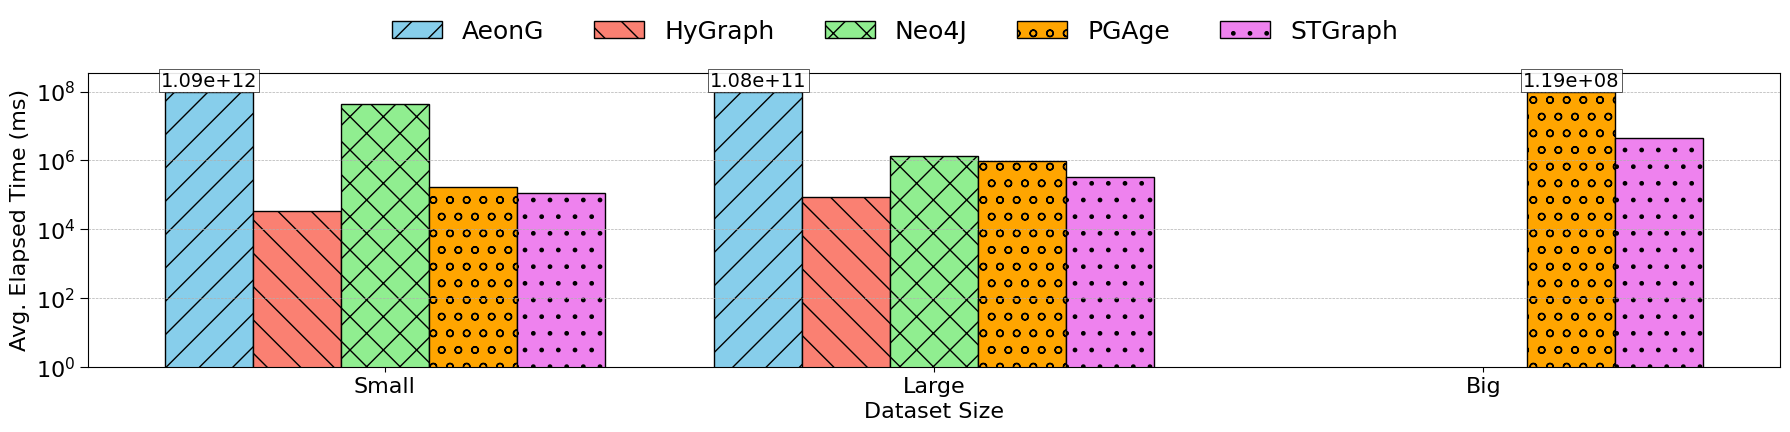

In [875]:
print_ingestion_statistics(ingestion_statistics)

Query statistics - <b>different</b> selectivity across dataset size

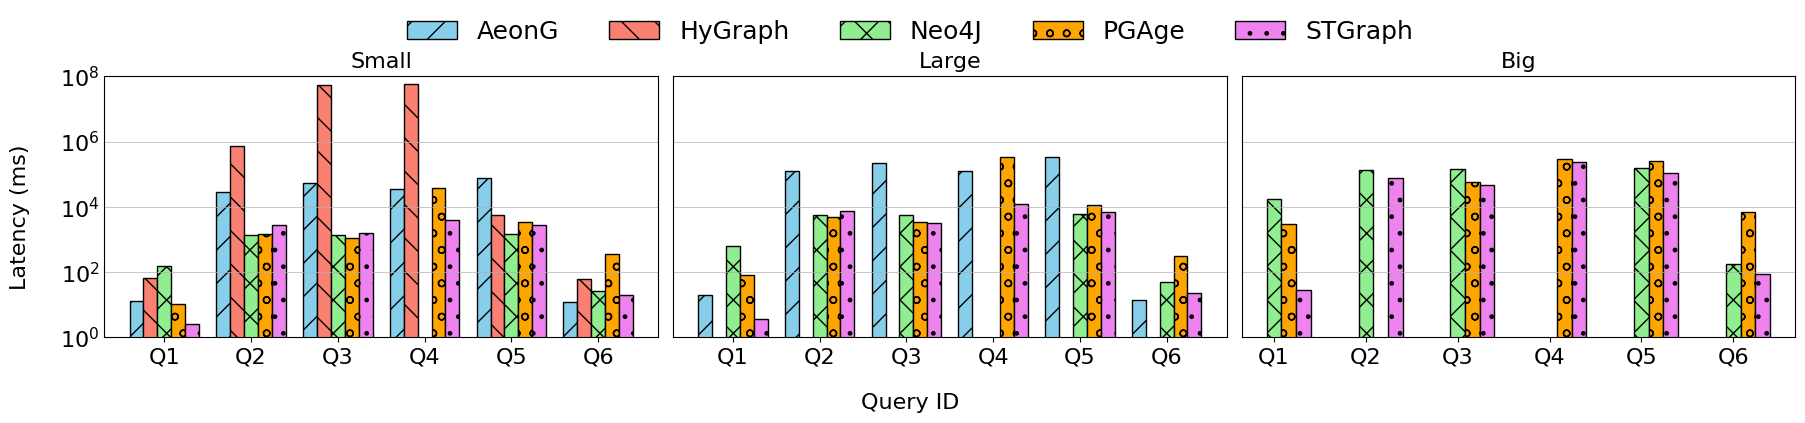

In [879]:
query_statistics_different_selectivity = query_statistics.loc[query_statistics["querySelectivity"] == "increased"]
print_query_statistics(query_statistics_different_selectivity, "query_statistics_increased")

In [872]:
query_statistics_different_selectivity = query_statistics_different_selectivity.loc[((query_statistics_different_selectivity["model"] == "STGraph") | (query_statistics_different_selectivity["model"] == "PGAge") | (query_statistics_different_selectivity["model"] == "Neo4J")) & (query_statistics_different_selectivity["datasetSize"] == "Big")]
query_statistics_different_selectivity.groupby(by=["queryName", "model"]).agg({"elapsedTime": "mean"})

elapsedTime
queryName             model                 
AgentHistory          Neo4J       172.405000
                      PGAge      6946.162500
                      STGraph      86.214286
AgentOutlier          Neo4J    159151.393750
                      PGAge    248474.622000
                      STGraph  106459.571429
EnvironmentAggregate  Neo4J    130035.456000
                      STGraph   75804.380952
EnvironmentAggregate2 Neo4J    135568.810000
                      PGAge     21751.338000
                      STGraph   48035.923077
EnvironmentCoverage   Neo4J     17351.847778
                      PGAge      2952.172500
                      STGraph      28.076923
EnvironmentOutlier    PGAge    294772.324000
                      STGraph  231440.846154
MaintenanceOwners     Neo4J    141987.900000
                      PGAge     55860.412500
                      STGraph   47639.307692

#### Query perforamnces w.r.t. different temporal filter coverage

Big dataset

Processing model: Neo4J for query: Q2 with 50 entries.
Resulting series for model Neo4J:
temporalRangeIndex
0    126252.990
1    139858.198
2    152988.716
3    165842.656
4    181118.512
5    193592.368
6    205862.626
7    218109.246
8    232067.448
9    246554.318
Name: elapsedTime, dtype: float64

Valid indices for model Neo4J: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Processing model: PGAge for query: Q2 with 100 entries.
Resulting series for model PGAge:
temporalRangeIndex
0     106050.544
1     214822.337
2     322080.983
3     432672.481
4     537632.527
5     648166.703
6     752331.812
7     873412.968
8     975260.212
9    1080522.666
Name: elapsedTime, dtype: float64

Valid indices for model PGAge: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Processing model: STGraph for query: Q2 with 97 entries.
Resulting series for model STGraph:
temporalRangeIndex
0     73536.300000
1     93802.800000
2    112893.600000
3    134985.300000
4    152162.500000
5    174760.300000
6    186526.200000
7    207750.33

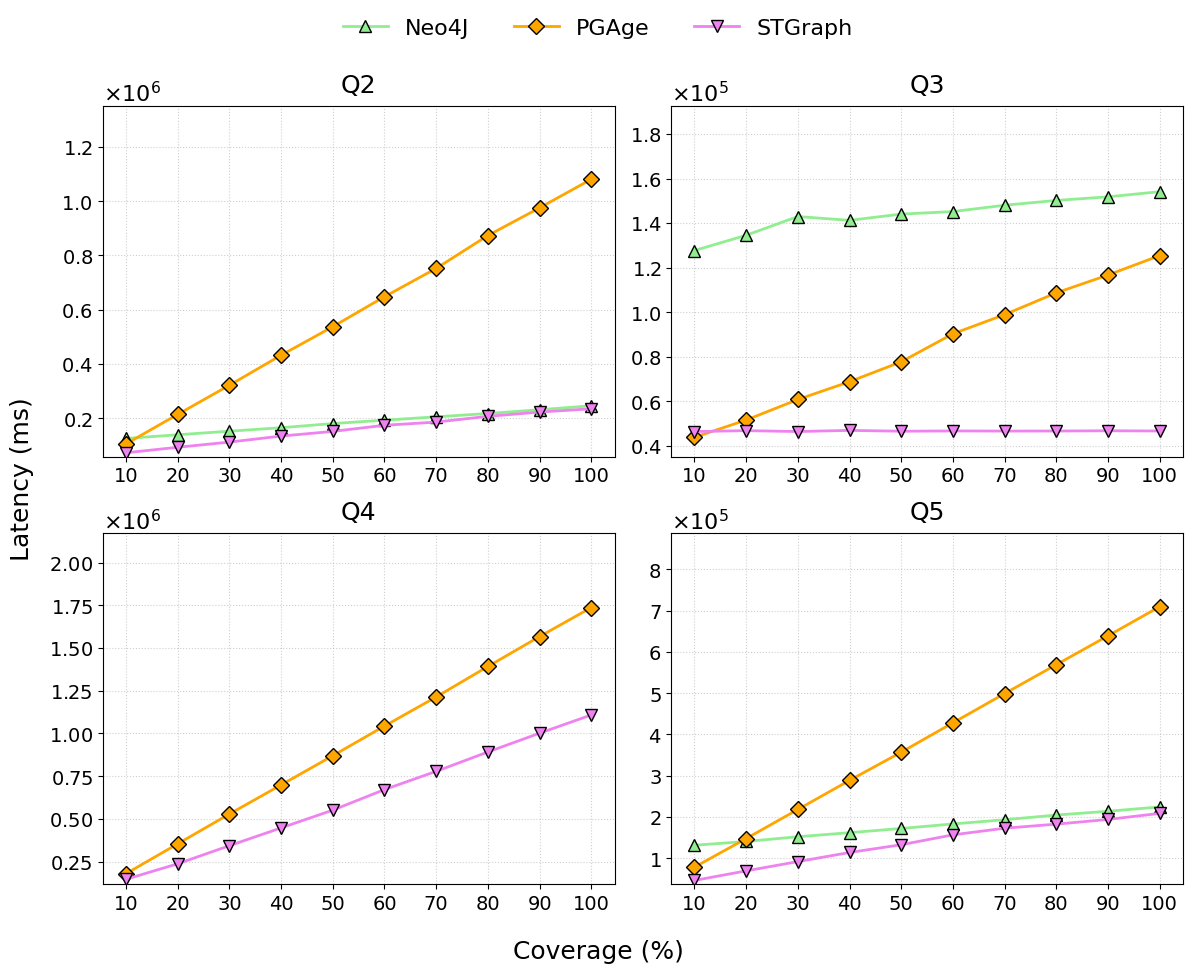

In [873]:
quer_dset = query_statistics.loc[query_statistics["querySelectivity"] == "scaled"]
plot_execution_times_selectivity(quer_dset, "Big", 1)

Large dataset

In [838]:
quer_dset.loc[(quer_dset["model"] == "STGraph") & (quer_dset["querySelectivity"] == "scaled")]

,test_id,model,dataset,datasetSize,threads,queryName,queryType,elapsedTime,numEntities,numMachines,querySelectivity,temporalRangeIndex,iteration
10530,4eb6e0a1-f002-4897-ab7a-2bbcb2372622,STGraph,smartbench,Large,1,EnvironmentCoverage,edgesDirection,50.0,22,1,scaled,0,0
10531,4eb6e0a1-f002-4897-ab7a-2bbcb2372622,STGraph,smartbench,Large,1,EnvironmentCoverage,edgesDirection,9.0,22,1,scaled,1,0
10532,4eb6e0a1-f002-4897-ab7a-2bbcb2372622,STGraph,smartbench,Large,1,EnvironmentCoverage,edgesDirection,8.0,22,1,scaled,2,0
10533,4eb6e0a1-f002-4897-ab7a-2bbcb2372622,STGraph,smartbench,Large,1,EnvironmentCoverage,edgesDirection,9.0,22,1,scaled,3,0
10534,4eb6e0a1-f002-4897-ab7a-2bbcb2372622,STGraph,smartbench,Large,1,EnvironmentCoverage,edgesDirection,8.0,22,1,scaled,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13140,ed5e7c7b-d759-4eda-a6c5-229e82b74b04,STGraph,smartbench,Big,1,EnvironmentAggregate,edgesDirection,166592.0,112,1,scaled,5,6
13141,ed5e7c7b-d759-4eda-a6c5-229e82b74b04,STGraph,smartbench,Big,1,EnvironmentAggregate,edgesDirection,184688.0,112,1,scaled,6,6
13142,ed5e7c7b-d759-4eda-a6c5-229e82b74b04,STGraph,smartbench,Big,1,EnvironmentAggregate,edgesDirection,202690.0,112,1,scaled,7,6
13143,ed5e7c7b-d759-4eda-a6c5-229e82b74b04,STGraph,smartbench,Big,1,EnvironmentAggregate,edgesDirection,218613.0,112,1,scaled,8,6


In [839]:
quer_dset.loc[(quer_dset["model"] == "AeonG") & (quer_dset["querySelectivity"] == "scaled")]

,test_id,model,dataset,datasetSize,threads,queryName,queryType,elapsedTime,numEntities,numMachines,querySelectivity,temporalRangeIndex,iteration
2208,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,AgentHistory,edgesDirection,14.0,-1,1,scaled,3,1
2209,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,AgentHistory,edgesDirection,15.0,-1,1,scaled,7,1
2211,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,EnvironmentCoverage,edgesDirection,22.0,-1,1,scaled,9,1
2214,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,AgentOutlier,edgesDirection,186352.0,-1,1,scaled,1,1
2215,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,EnvironmentCoverage,edgesDirection,18.0,-1,1,scaled,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,EnvironmentOutlier,edgesDirection,408742.0,-1,1,scaled,5,1
2345,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,AgentOutlier,edgesDirection,465898.0,-1,1,scaled,4,1
2346,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,AgentHistory,edgesDirection,13.0,-1,1,scaled,6,2
2347,68807b4a-9dff-48e8-9242-f520f4ccfe19,AeonG,smartbench,Large,1,MaintenanceOwners,edgesDirection,300121.0,-1,1,scaled,3,1


Processing model: AeonG for query: Q2 with 6 entries.
Resulting series for model AeonG:
temporalRangeIndex
0     95415.0
1    186926.0
2    286440.0
3    376085.0
4    469209.0
5    560351.0
Name: elapsedTime, dtype: float64

Valid indices for model AeonG: []
Processing model: Neo4J for query: Q2 with 200 entries.
Resulting series for model Neo4J:
temporalRangeIndex
0    5453.4895
1    5705.6895
2    6080.8015
3    6554.6955
4    6805.0300
5    7153.0500
6    7661.1805
7    7938.6515
8    8395.2385
9    8738.0710
Name: elapsedTime, dtype: float64

Valid indices for model Neo4J: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Processing model: PGAge for query: Q2 with 140 entries.
Resulting series for model PGAge:
temporalRangeIndex
0     4365.655000
1     7813.937143
2    11450.504286
3    15275.582143
4    18784.118571
5    22619.565000
6    26130.282857
7    29888.291429
8    33716.753571
9    37440.356429
Name: elapsedTime, dtype: float64

Valid indices for model PGAge: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9

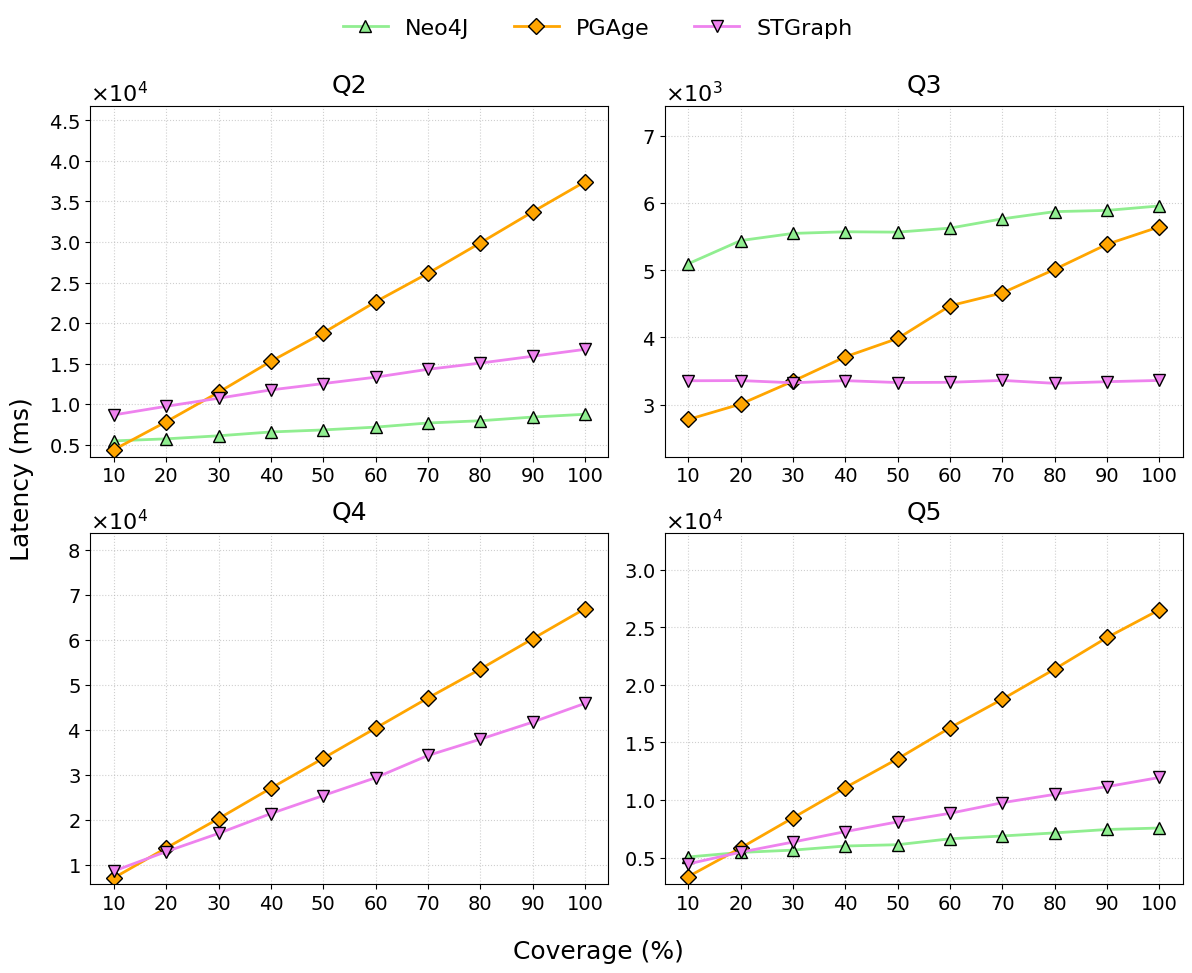

In [861]:
quer_dset = query_statistics.loc[query_statistics["querySelectivity"] == "scaled"]
plot_execution_times_selectivity(quer_dset, "Large", 1)


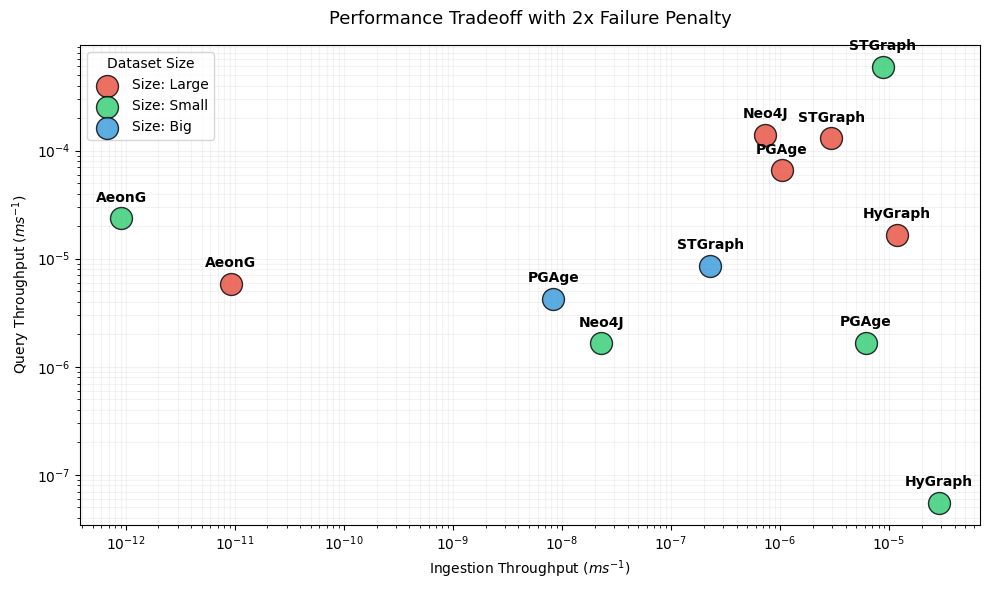

In [862]:
# 
import pandas as pd
import matplotlib.pyplot as plt

def plot_performance_penalty_tradeoff(df_queries, df_ingestion):
    """
    Plots performance tradeoff. If a query is missing for a model, it imputes 
    a penalty: 2x the worst time recorded by other models for that specific query.
    """
    # 1. Copy and normalize
    q = df_queries.copy()
    i = df_ingestion.copy()
    
    for df in [q, i]:
        df['model'] = df['model'].astype(str).str.strip()
        df['datasetSize'] = df['datasetSize'].astype(str).str.strip()

    # 2. Thread filter
    q = q[q['threads'] == 1]
    i = i[i['threads'] == 1]

    # 3. Penalty Imputation Logic
    all_queries = q['queryName'].unique()
    all_models = q['model'].unique()
    all_sizes = q['datasetSize'].unique()
    
    imputed_rows = []

    for size in all_sizes:
        for query in all_queries:
            # Find the worst time (max) for this specific query and size among all models
            worst_time = q[(q['queryName'] == query) & (q['datasetSize'] == size)]['elapsedTime'].max()
            
            # If no one completed it, we can't impute (should not happen in a benchmark)
            if pd.isna(worst_time): continue
            
            penalty_time = worst_time * 2
            
            for model in all_models:
                # Check if the model is missing this specific query
                check = q[(q['model'] == model) & (q['datasetSize'] == size) & (q['queryName'] == query)]
                
                if check.empty:
                    # Create a penalty row
                    imputed_rows.append({
                        'model': model,
                        'datasetSize': size,
                        'queryName': query,
                        'elapsedTime': penalty_time,
                        'threads': 1
                    })

    # Add penalty rows to the original dataframe
    if imputed_rows:
        q = pd.concat([q, pd.DataFrame(imputed_rows)], ignore_index=True)

    # 4. Aggregation
    q_agg = q.groupby(['model', 'datasetSize'])['elapsedTime'].mean().reset_index()
    q_agg.rename(columns={'elapsedTime': 'query_time_ms'}, inplace=True)

    i_agg = i.groupby(['model', 'datasetSize'])['elapsedTime'].mean().reset_index()
    i_agg.rename(columns={'elapsedTime': 'ingestion_time_ms'}, inplace=True)

    # 5. Merge and Throughput
    df_plot = pd.merge(q_agg, i_agg, on=['model', 'datasetSize'])
    df_plot['ingestion_throughput'] = 1 / df_plot['ingestion_time_ms'] 
    df_plot['query_throughput'] = 1 / df_plot['query_time_ms']

    # 6. Plotting
    plt.figure(figsize=(10, 6))
    colors = {'Small': '#2ecc71', 'Large': '#e74c3c'}

    for size in df_plot['datasetSize'].unique():
        subset = df_plot[df_plot['datasetSize'] == size]
        plt.scatter(
            subset['ingestion_throughput'], subset['query_throughput'], 
            s=250, c=colors.get(size, '#3498db'),
            label=f"Size: {size}", alpha=0.8, edgecolors='black', zorder=3
        )

    for _, row in df_plot.iterrows():
        plt.annotate(row['model'], (row['ingestion_throughput'], row['query_throughput']),
                     textcoords="offset points", xytext=(0, 12), ha='center', fontweight='bold')

    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'Ingestion Throughput ($ms^{-1}$)'); plt.ylabel(r'Query Throughput ($ms^{-1}$)')
    plt.title('Performance Tradeoff with 2x Failure Penalty', fontsize=13, pad=15)
    plt.grid(True, which="both", ls="-", alpha=0.15)
    plt.legend(title="Dataset Size")
    plt.tight_layout()
    plt.show()

# Run
plot_performance_penalty_tradeoff(query_statistics, ingestion_statistics)

### STGraph - Scale Out

Ingestion stats

   numMachines  graphElapsedTime  tsElapsedTime
0            2      83512.600000   1.038752e+07
1            4     109115.862745   5.559638e+06
2            8     134872.454545   3.425224e+06


/tmp/ipykernel_722/2101256888.py:37: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(
/tmp/ipykernel_722/2101256888.py:65: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],


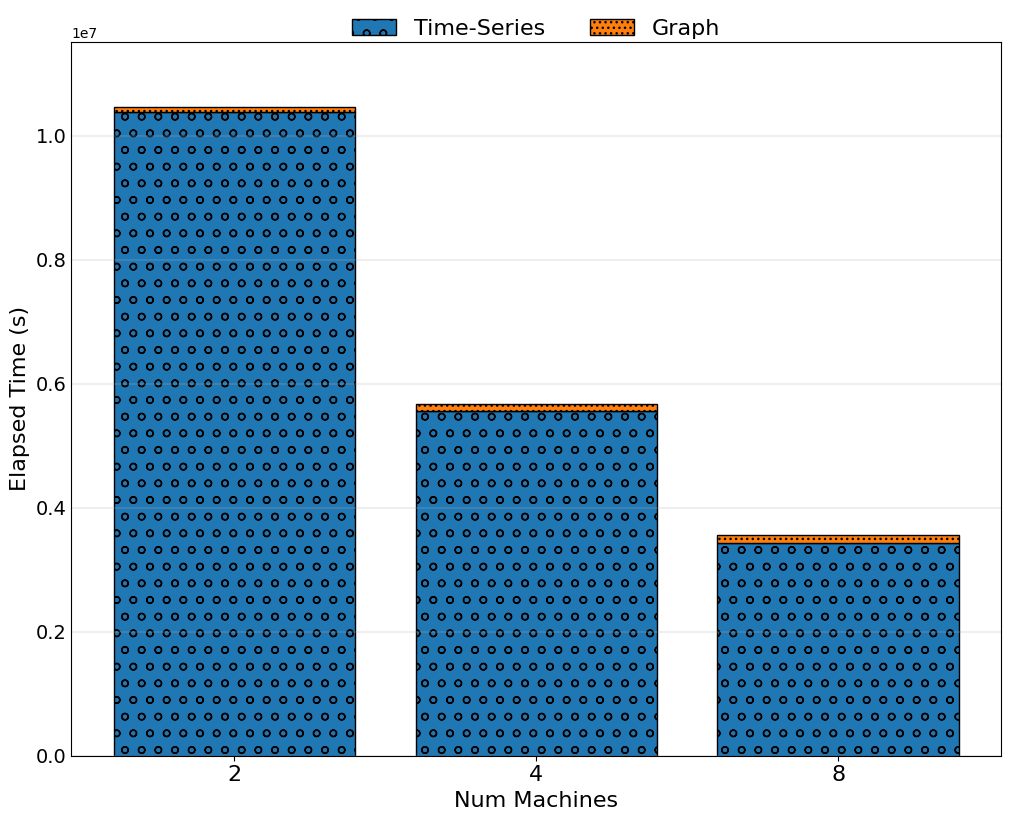

In [ ]:
def plot_stacked_elapsed_times(df, model_filter, threads_filter, dataset_filter):
    """  
    Build a stacked bar chart similar to the Tableau screenshot, using a consistent style.  

    Parameters:  
    - df: pandas DataFrame containing columns:  
        ['model', 'threads', 'datasetSize', 'numMachines', 'graphElapsedTime', 'tsElapsedTime']  
    - model_filter: str, e.g. 'STGraph'  
    - threads_filter: int, e.g. 1  
    - dataset_filter: str, e.g. 'big_long'  
    - unit: 'ms', 's', or 'min' (default 'ms')  
    """  


    # Filter data according to model, threads, and dataset size  
    filtered = df[  
        (df["model"] == model_filter) &  
        (df["threads"] == threads_filter) &  
        (df["datasetSize"] == dataset_filter)  
    ]  

    # Group by number of machines and compute the mean elapsed times  
    grouped = filtered.groupby("numMachines")[["graphElapsedTime", "tsElapsedTime"]].mean().reset_index()  
    grouped = grouped.sort_values("numMachines")  

    print(grouped)

    # Discrete x positions for compact bars  
    x = np.arange(len(grouped))  

    # Create figure and axes  
    fig, ax = plt.subplots(figsize=(12, 6))  

    # Draw stacked bars  
    bottom = np.zeros(len(grouped))  
    for i, col in enumerate(["tsElapsedTime", "graphElapsedTime"]):  
        ax.bar(  
            x,  
            grouped[col],  
            bottom=bottom,  
            color=colors[i],  
            edgecolor='black',  
            hatch=patterns[i],  
            label=col.replace("ElapsedTime", " Latency")
        )
        bottom += grouped[col].values

    # Set X-axis labels only for actual number of machines
    ax.set_xticks(x)
    ax.set_xticklabels(grouped["numMachines"], fontsize=16)
    ax.set_xlabel("Num Machines", fontsize=16)

    # ax.set_yscale("log")

    # Y-axis – linear scale with extra space above maximum
    ax.set_ylabel(f"Elapsed Time (s)", fontsize=16)
    ax.set_ylim(0, bottom.max() * 1.1)
    ax.tick_params(axis='y', which='both', length=0,labelsize=14,)  # remove tick lines

    # Horizontal grid lines for reference
    ax.grid(True, axis="y", linewidth=0.3)

    # Custom legend for stacked bars
    handles = [
        mpatches.Patch(facecolor=colors[i], edgecolor='black', hatch=patterns[i],
                       label=col.replace("ElapsedTime", " Latency"))
        for i, col in enumerate(["Time-Series", "Graph"])
    ]
    ax.legend(handles=handles, loc='upper center', ncol=2, frameon=False,
              bbox_to_anchor=(0.5, 1.06), fontsize=16)

    # Adjust layout and save figure as SVG
    plt.subplots_adjust(top=1.3, wspace=0.3)
    plt.savefig(os.path.join(figures_path, f"scaleout_ingestion_statistics.svg"), format='svg', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage:
plot_stacked_elapsed_times(ingestion_statistics.loc[ingestion_statistics["numMachines"] > 1], "STGraph", 16, "Big_long")


Query Latency

2 machines -> [np.float64(45648.76666666667), np.float64(9506.833333333334), np.float64(293696.1666666667), np.float64(47680.8)]
4 machines -> [np.float64(28419.166666666668), np.float64(10230.016666666666), np.float64(167119.61666666667), np.float64(29613.25)]
8 machines -> [np.float64(17918.866666666665), np.float64(11416.733333333334), np.float64(80083.46666666666), np.float64(20084.633333333335)]


/tmp/ipykernel_722/3686497003.py:43: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "dils". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.bar(


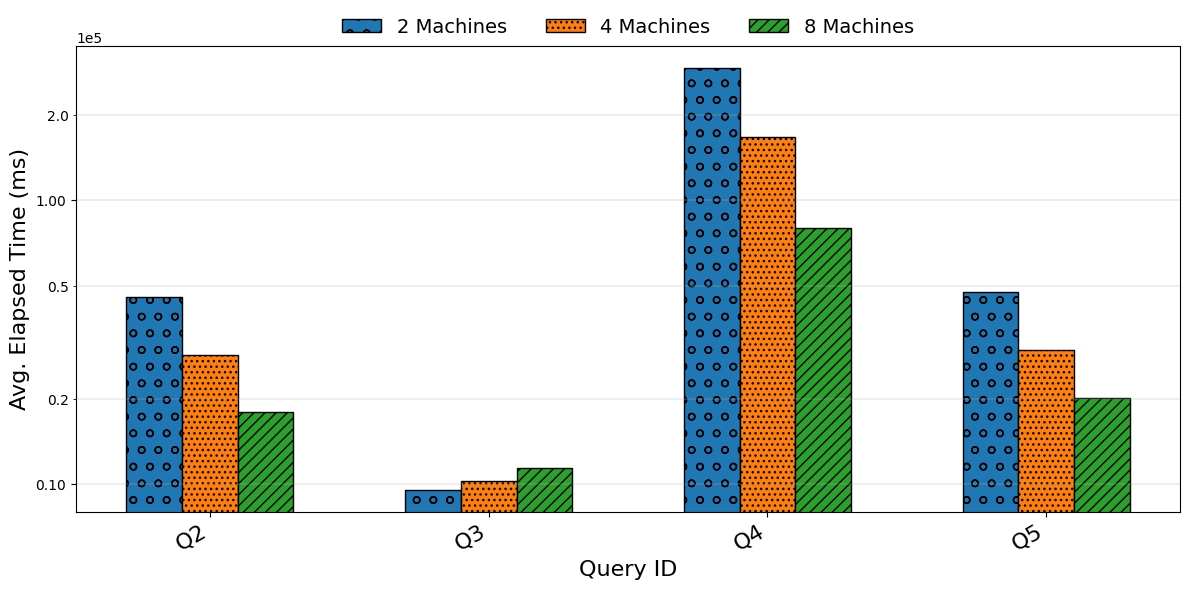

In [ ]:
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter

# Copy dataframe
df = query_statistics.copy(deep=True)
df = df.loc[(query_statistics["queryName"] != "AgentHistory") & (query_statistics["queryName"] != "EnvironmentCoverage")]
df["queryID"] = df["queryName"].apply(lambda row: query_names[row])
# Filter as in Tableau dashboard
df = df[
    (df["threads"] == 16) &
    (df["datasetSize"] == "Big_long") &
    (df["model"] == "STGraph")
]

# Compute mean elapsed time grouped by Query Name and Num Machines
grouped = (
    df.groupby(["queryID", "numMachines"])["elapsedTime"]
    .mean()
    .reset_index()
)

# Sort query names consistently
query_names_sorted = sorted(grouped["queryID"].unique())

# Sort numMachines as numeric order (2,4,8,...)
machines_sorted = sorted(grouped["numMachines"].unique())

# X positions
x = np.arange(len(query_names_sorted))
bar_width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))

# Draw bars
for i, m in enumerate(machines_sorted):
    # Values for each query
    values = [
        grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)]["elapsedTime"].values[0]
        if not grouped[(grouped["queryID"] == q) & (grouped["numMachines"] == m)].empty
        else np.nan
        for q in query_names_sorted
    ]
    print(f"{m} machines ->", list(values))
    ax.bar(
        x + i * bar_width,
        values,
        width=bar_width,
        color=colors[i % len(colors)],
        edgecolor='black',
        hatch=patterns[i % len(patterns)],
        label=f"{m} Machines"
    )

# X-axis
ax.set_xticks(x + bar_width * (len(machines_sorted)-1) / 2)
ax.set_xticklabels(query_names_sorted, rotation=30, ha='right', fontsize=16)
ax.set_xlabel("Query ID", fontsize=16)

# Y-axis
ax.set_ylabel("Avg. Elapsed Time (ms)", fontsize=16)
ax.set_yscale("log")

# Major ticks = potenze di 10
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))

ax.yaxis.set_minor_locator(LogLocator(base=10.0,
                                      subs=[1,2,5],
                                      numticks=50))

sf = ScalarFormatter()
sf.set_scientific(True)        # forza notazione scientifica
sf.set_powerlimits((0,0))      # forza esponente per tutti i valori
ax.yaxis.set_major_formatter(sf)
ax.yaxis.set_minor_formatter(sf)

# Grid
ax.grid(True, which="both", axis="y", linewidth=0.3)

# Legend
ax.legend(
    loc="upper center",
    ncol=len(machines_sorted),
    frameon=False,
    fontsize=14,
    bbox_to_anchor=(0.5, 1.10)
)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "scaleout_query_statistics.svg"), format='svg', bbox_inches='tight')
plt.show()